# Description of the Problem

The goal of this project is to build a machine learning model that identifies real disaster-related tweets from a dataset of around 10,000 hand-classified tweets. The task focuses on natural language processing (NLP) to distinguish genuine emergency announcements from metaphorical or non-disaster tweets, such as a tweet that ueses "ABLAZE" metaphorically versus an emergency fire announcement. Due to the importance of Twitter as a real-time communication channel, this work can help relief organizations and news agencies better monitor the platform.

In [1]:
import re
import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Dense, Input, LSTM, Bidirectional, Dropout, SpatialDropout1D, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
train_loc = 'train.csv'
test_loc = 'test.csv'

In [3]:
train_df = pd.read_csv(train_loc)
test_df = pd.read_csv(test_loc)

In [4]:
# Display basic information about the dataframe
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

In [5]:
# Before saying anything about distribution of variables, we want to make sure we drop any duplicate entries if any exist
print('train duplicate text:', train_df.duplicated(subset=['text']).sum())

train_df.drop_duplicates(subset=['text'], inplace=True)

train duplicate text: 110


# Exploratory Data Analysis

target
0    4305
1    3198
Name: count, dtype: int64


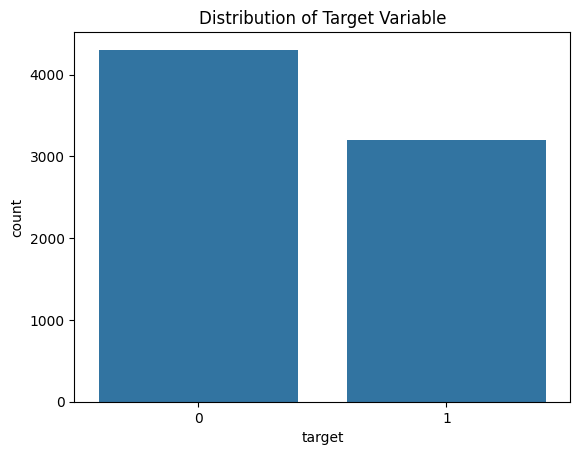

target
0    0.57377
1    0.42623
Name: proportion, dtype: float64


In [6]:
# Explore the distribution of the target variable
print(train_df['target'].value_counts())
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

print(train_df['target'].value_counts(normalize=True))

There is a slight mismatch in the proportion of tweets in each category, with non-disaster tweets accounting for 57% of the data and disaster tweets accounting for only 43%. If we see overfitting of the model down the line, this might be one area to improve on by dropping a selection of non-disaster tweets.

In [7]:
# From info we can see there are a number of null fields. Lets check the counts
df_null = train_df.isnull().sum()
print(df_null)

id             0
keyword       56
location    2482
text           0
target         0
dtype: int64


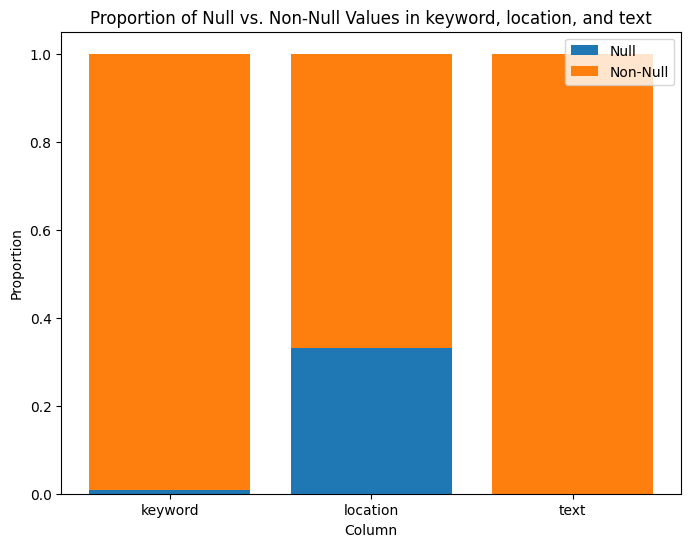

In [8]:
null_counts = pd.DataFrame({
    'Column': ['keyword', 'location', 'text'],
    'Nulls': [train_df['keyword'].isnull().sum(), train_df['location'].isnull().sum(), train_df['text'].isnull().sum()],
    'Non-Nulls': [train_df['keyword'].notnull().sum(), train_df['location'].notnull().sum(), train_df['text'].notnull().sum()]
})

null_counts['Null Proportion'] = null_counts['Nulls'] / len(train_df)
null_counts['Non-Null Proportion'] = null_counts['Non-Nulls'] / len(train_df)

plt.figure(figsize=(8, 6))
plt.bar(null_counts['Column'], null_counts['Null Proportion'], label='Null')
plt.bar(null_counts['Column'], null_counts['Non-Null Proportion'], bottom=null_counts['Null Proportion'], label='Non-Null')
plt.title('Proportion of Null vs. Non-Null Values in keyword, location, and text')
plt.xlabel('Column')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [9]:
# Now we can look at distribution of null values between each category

nulls_target_1 = train_df[train_df['target'] == 1].isnull().sum()
nulls_target_0 = train_df[train_df['target'] == 0].isnull().sum()

# Compare the number of null entries for each target value
print("Null entries where target is 1:\n", nulls_target_1)
print("\nNull entries where target is 0:\n", nulls_target_0)


Null entries where target is 1:
 id             0
keyword       37
location    1044
text           0
target         0
dtype: int64

Null entries where target is 0:
 id             0
keyword       19
location    1438
text           0
target         0
dtype: int64


In [10]:
# Let's also compare this to the count of null values in our test set as that may inform our data processing
df_null_test = test_df.isnull().sum()
print("Null counts test_df:\n")
print(df_null_test)

Null counts test_df:

id             0
keyword       26
location    1105
text           0
dtype: int64


Now we can investigate the column values themselves

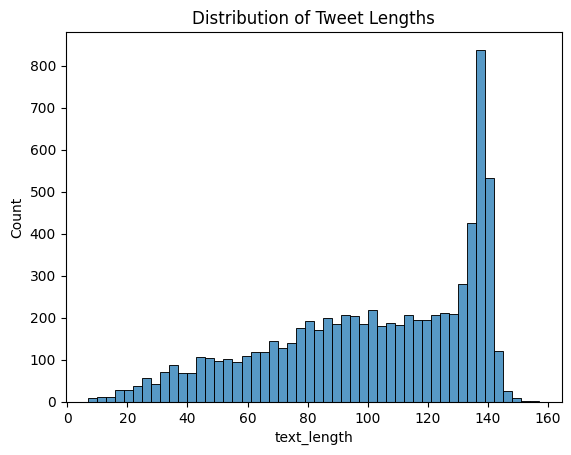

count    7503.000000
mean      100.880581
std        33.819457
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64


In [11]:
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(train_df['text_length'], bins=50)
plt.title('Distribution of Tweet Lengths')
plt.show()
print(train_df['text_length'].describe())


Top 10 most frequent values in 'keyword':
keyword
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
siren          40
evacuate       40
twister        40
windstorm      40
Name: count, dtype: int64


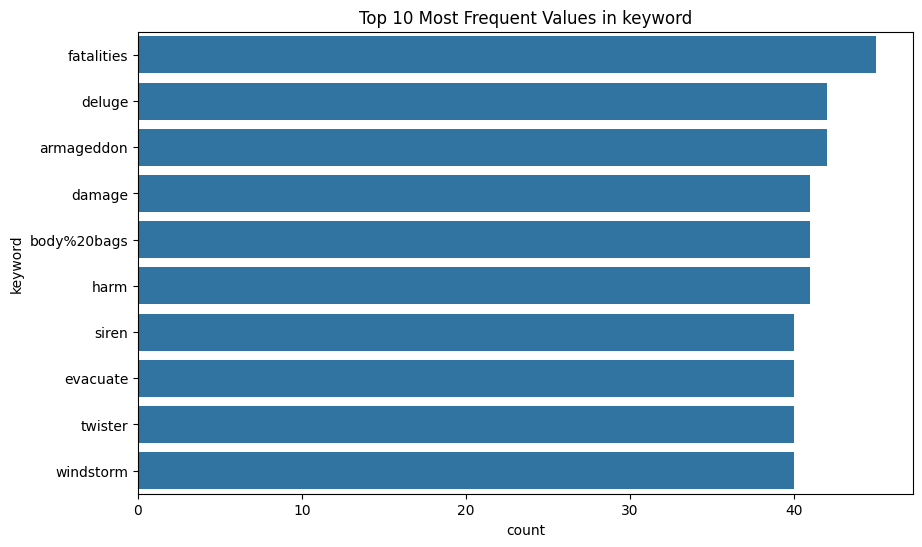


Top 10 most frequent values in 'location':
location
USA                104
New York            71
United States       50
London              45
Canada              29
Los Angeles, CA     26
UK                  26
Nigeria             23
India               21
Washington, DC      21
Name: count, dtype: int64


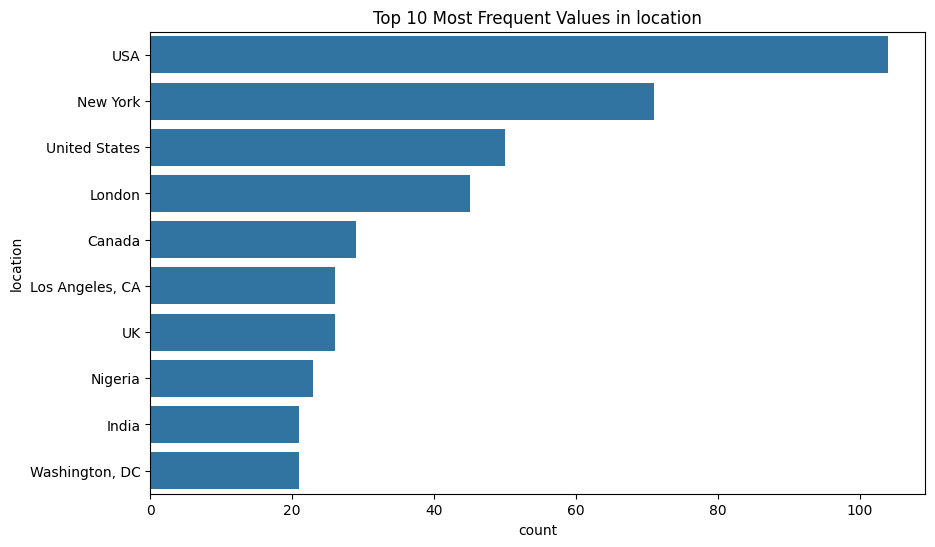

In [12]:
for col in ['keyword', 'location']:
    print(f"\nTop 10 most frequent values in '{col}':")
    print(train_df[col].value_counts().head(10))
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=train_df, order=train_df[col].value_counts().index[:10])
    plt.title(f'Top 10 Most Frequent Values in {col}')
    plt.show()

Keyword values alone don't actually tell us the full story though. What we really care about is the mean value where a value at or near 1 would symbolize that the keyword mainly appears in disaster tweets.


Keywords with highest mean target values:
keyword
derailment            1.000000
debris                1.000000
wreckage              1.000000
outbreak              0.974359
oil%20spill           0.973684
typhoon               0.972222
suicide%20bombing     0.968750
suicide%20bomber      0.967742
bombing               0.928571
nuclear%20disaster    0.911765
Name: target, dtype: float64


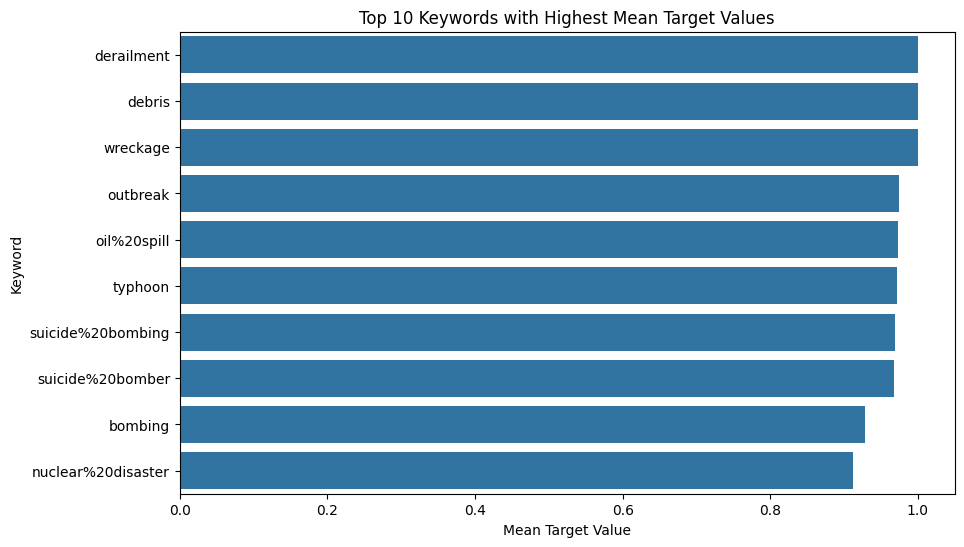

In [13]:
# visualization of the relationship between keyword and target variable
keyword_target = train_df.groupby('keyword')['target'].mean().sort_values(ascending=False)
print("\nKeywords with highest mean target values:")
print(keyword_target.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_target.values[:10], y=keyword_target.index[:10])
plt.title('Top 10 Keywords with Highest Mean Target Values')
plt.xlabel('Mean Target Value')
plt.ylabel('Keyword')
plt.show()


Keywords with Lowest mean target values:
keyword
aftershock     0.000000
body%20bags    0.024390
ruin           0.027027
blazing        0.029412
body%20bag     0.030303
electrocute    0.031250
screaming      0.055556
traumatised    0.057143
panicking      0.060606
blew%20up      0.060606
Name: target, dtype: float64


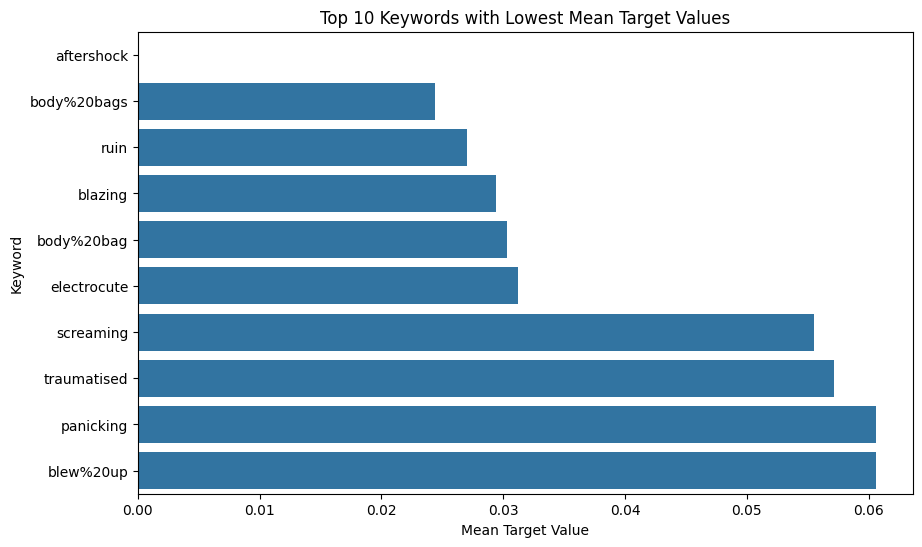

In [14]:
# visualization of the relationship between keyword and target variable
keyword_target = train_df.groupby('keyword')['target'].mean().sort_values(ascending=True)
print("\nKeywords with Lowest mean target values:")
print(keyword_target.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_target.values[:10], y=keyword_target.index[:10])
plt.title('Top 10 Keywords with Lowest Mean Target Values')
plt.xlabel('Mean Target Value')
plt.ylabel('Keyword')
plt.show()

**Keywords**

From the keywords we can already get a sense of the issue. It is very hard to tell from keywords alone what is a real emergency. As a human reader "body bags" and "blew up" all sound very serious despite their low mean scores. Let's investigate the body of some of those tweets.

In [15]:
df_train_bodybags = train_df[train_df['keyword'] == 'body%20bags']
display(df_train_bodybags['text'].head(10))

,text
1018,@FoxNews @JenGriffinFNC When you call to repor...
1019,Micom 2015 Summer Contrast Candy Color Bowknot...
1020,HOBO Hobo Vintage Shira Convertible BÛ_ $238....
1021,Child Shoulder Bags PVC Shoulder Book Bag Cart...
1022,Womens Buckle Casual Stylish Shoulder Handbags...
1023,Ain't no bags in the trunk it's a body
1024,BESTSELLER! Fossil Dawson Mini Cross Body Bag ...
1025,@BoomerangTime @RSKarim1 @sopameer @wattashit3...
1026,The Body Bags has a show on 08/07/2015 at 07:3...
1027,BODY BAGS! https://t.co/0McXc68GZD


Now it makes a bit more sense. Body bag can also refer to a style of handbag. Issues like this may make us reluctant to overly rely on the keyword column

In [16]:
# Cleaning step

def clean_text(text):
    text = html.unescape(text) # Handle HTML entities
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#(\w+)', r'\1', text) # Remove '#' from hashtags but keep word
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphanumeric characters (keeps spaces)
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [17]:
# Prepend Keyword column to text

train_df['keyword'] = train_df['keyword'].fillna('nokeyword')
train_df['keyword_cleaned'] = train_df['keyword'].str.replace('%20', ' ', regex=False)
train_df['text_with_keyword'] = train_df['keyword_cleaned'] + ' ' + train_df['cleaned_text']

# Word Embedding

I will use Keras [Text Vectorization](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/) to transform text into word embeddings.

The tokenization step splits the text into individual units based on whitespace then outputs integer indices, one integer index per split string token.

In [18]:
# Set up vectorization for sequences of integers (tokens)
max_tokens = 20000
sequence_length = 160

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=sequence_length,
)

In [19]:
# Prepare the vocabulary
vectorize_layer.adapt(train_df['text_with_keyword'])

# Model Building

I will start with a standard LSTM model. An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) that is capable of learning long-term dependencies in sequential data.

In [20]:
model_LSTM = Sequential([
    Input(shape=(1,), dtype='string'),
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 160)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 160, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,609,473 (9.95 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training and Performance

In [21]:
# Test and Train Split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text_with_keyword'], train_df['target'], test_size=0.2, random_state=42)

In [22]:
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [23]:
EPOCHS = 10
history_LSTM = model_LSTM.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.6585 - loss: 0.6185 - val_accuracy: 0.7848 - val_loss: 0.4778
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.8596 - loss: 0.3395 - val_accuracy: 0.7835 - val_loss: 0.5288
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - accuracy: 0.9241 - loss: 0.2083 - val_accuracy: 0.7742 - val_loss: 0.6280
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 283ms/step - accuracy: 0.9512 - loss: 0.1386 - val_accuracy: 0.7742 - val_loss: 0.6471
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - accuracy: 0.9673 - loss: 0.0990 - val_accuracy: 0.7575 - val_loss: 0.7156
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.9650 - loss: 0.1003 - val_accuracy: 0.7682 - val_loss: 0.8075
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.9762 - loss: 0.0683 - val_accuracy: 0.7528 - val_loss: 0.9620
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 273ms/step - accuracy: 0.9782 - loss: 0.0512 - val_accu

In [24]:
def plot_history(model_history):
    # Plot training & validation accuracy values
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

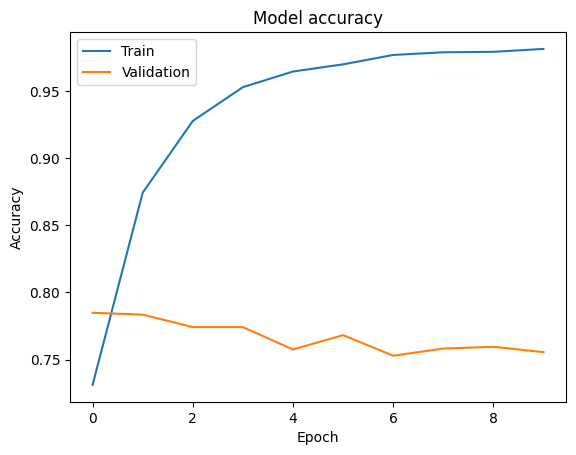

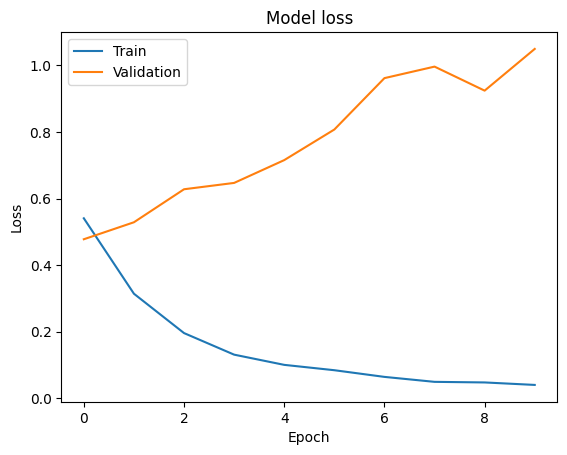

In [25]:
plot_history(history_LSTM)

From the history plots, we can see the model is massively overfitting. Including dropout in the model architecture could help reduce overfitting.

In [26]:
model_dropout = Sequential([
    Input(shape=(1,), dtype='string'),
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
    Dropout(0.3), # Dropout after embedding
    LSTM(64),
    Dropout(0.3), # Dropout after RNN
    Dense(1, activation='sigmoid')
])
# Re-compile
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dropout.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 160)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 160, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,609,473 (9.95 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_dropout = model_dropout.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.6376 - loss: 0.6347 - val_accuracy: 0.7868 - val_loss: 0.4843
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step - accuracy: 0.8454 - loss: 0.3685 - val_accuracy: 0.7855 - val_loss: 0.5241
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.9144 - loss: 0.2408 - val_accuracy: 0.7808 - val_loss: 0.5870
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9447 - loss: 0.1644 - val_accuracy: 0.7761 - val_loss: 0.6107
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 292ms/step - accuracy: 0.9642 - loss: 0.1098 - val_accuracy: 0.7648 - val_loss: 0.6469
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 307ms/step - accuracy: 0.9656 - loss: 0.0934 - val_accuracy: 0.7502 - val_loss: 0.7957
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 303ms/step - accuracy: 0.9727 - loss: 0.0783 - val_accuracy: 0.7781 - val_loss: 0.8912
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.9741 - loss: 0.0639 - val_accu

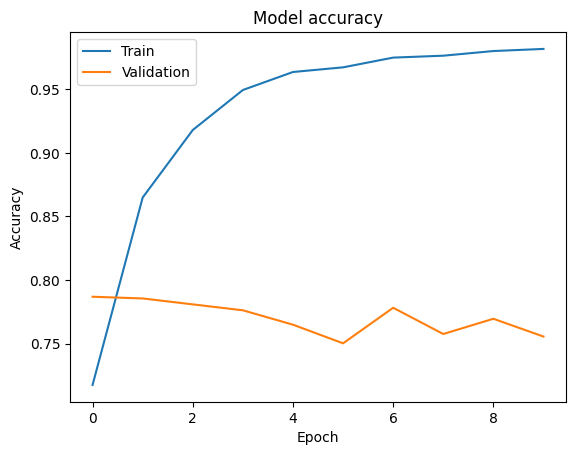

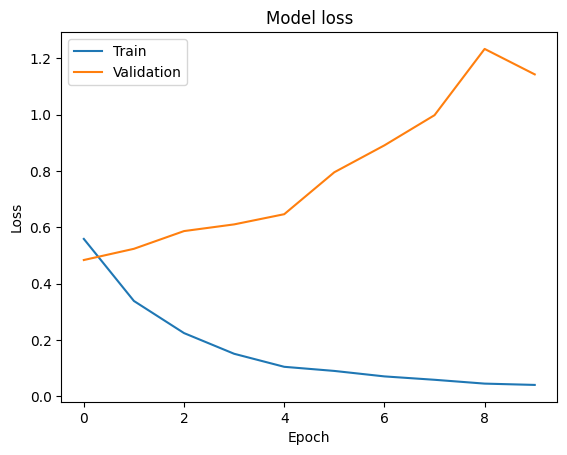

In [28]:
plot_history(history_dropout)

We can see from the dropout history that the model is still overfitting to the trainig data. Let's try to use stronger regularization

In [29]:
model_hyperparam_dropout = Sequential([
    Input(shape=(1,), dtype='string'),
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
    SpatialDropout1D(0.3),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_hyperparam_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hyperparam_dropout.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 160)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 160, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 160, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,609,473 (9.95 MB)

 Trainable params: 2,609,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_hyperparam_dropout = model_hyperparam_dropout.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 338ms/step - accuracy: 0.6206 - loss: 0.6420 - val_accuracy: 0.7861 - val_loss: 0.4781
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 331ms/step - accuracy: 0.8344 - loss: 0.3894 - val_accuracy: 0.7915 - val_loss: 0.4997
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 344ms/step - accuracy: 0.9002 - loss: 0.2706 - val_accuracy: 0.7908 - val_loss: 0.5608
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 331ms/step - accuracy: 0.9315 - loss: 0.1993 - val_accuracy: 0.7748 - val_loss: 0.5991
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step - accuracy: 0.9474 - loss: 0.1499 - val_accuracy: 0.7795 - val_loss: 0.6353
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.9606 - loss: 0.1190 - val_accuracy: 0.7755 - val_loss: 0.6663
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 331ms/step - accuracy: 0.9703 - loss: 0.0956 - val_accuracy: 0.7715 - val_loss: 0.7160
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 50s 428ms/step - accuracy: 0.9741 - loss: 0.0807 - val_accu

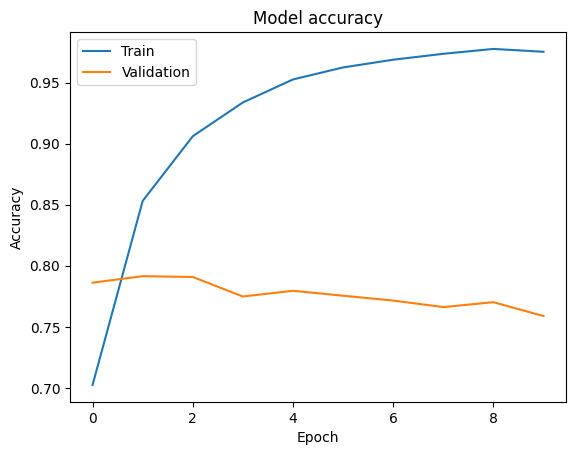

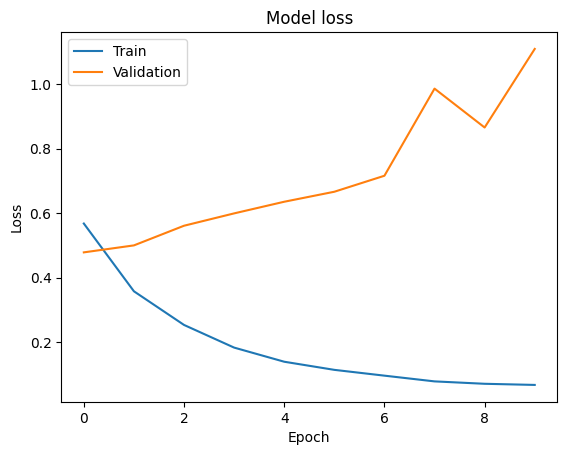

In [31]:
plot_history(history_hyperparam_dropout)

In [32]:
model = Sequential([
    Input(shape=(1,), dtype='string'),
    vectorize_layer,
    Embedding(max_tokens, 32,
              embeddings_regularizer=regularizers.l2(1e-4),
              mask_zero=True),
    SpatialDropout1D(0.4),
    LSTM(32,
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4),
         dropout=0.3,
         recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(1,
          activation='sigmoid',
          kernel_regularizer=regularizers.l2(1e-4))
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 160)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 160, 32)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 160, 32)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 648,353 (2.47 MB)

 Trainable params: 648,353 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.5776 - loss: 0.7153 - val_accuracy: 0.7768 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.7877 - loss: 0.5323 - val_accuracy: 0.7815 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.8527 - loss: 0.3908 - val_accuracy: 0.7968 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.8863 - loss: 0.3275 - val_accuracy: 0.7921 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.9154 - loss: 0.2722 - val_accuracy: 0.7921 - val_loss: 0.5310 - learning_rate: 5.0000e-04


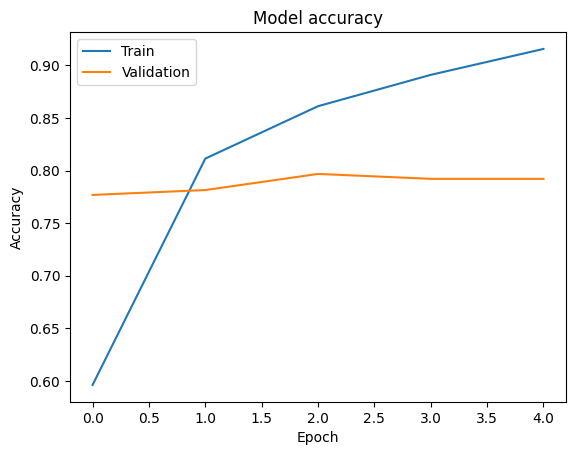

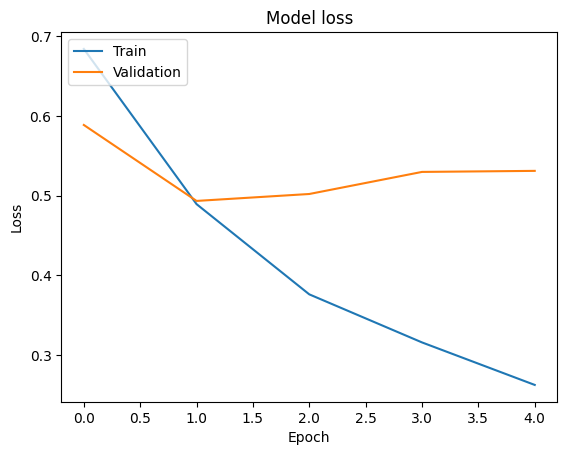

In [34]:
plot_history(history)

Slight increase in performance but still suffers from overfitting. Lets compare this to a model using GRU (Gated Recurrent Unit).

In [35]:
model = Sequential([
    Input(shape=(1,), dtype='string'),
    vectorize_layer,
    Embedding(max_tokens, 32,
              embeddings_regularizer=regularizers.l2(1e-4),
              mask_zero=True),
    SpatialDropout1D(0.4),
    GRU(32,
         kernel_regularizer=regularizers.l2(1e-4),
         recurrent_regularizer=regularizers.l2(1e-4),
         dropout=0.3,
         recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(1,
          activation='sigmoid',
          kernel_regularizer=regularizers.l2(1e-4))
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 160)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 160, 32)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 160, 32)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,369 (2.47 MB)

 Trainable params: 646,369 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.5579 - loss: 0.7151 - val_accuracy: 0.6249 - val_loss: 0.6602 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.7225 - loss: 0.5782 - val_accuracy: 0.7861 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.8451 - loss: 0.4052 - val_accuracy: 0.8008 - val_loss: 0.4984 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.8816 - loss: 0.3338 - val_accuracy: 0.7988 - val_loss: 0.5248 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.9086 - loss: 0.2729 - val_accuracy: 0.7875 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.9335 - loss: 0.2387 - val_accuracy: 0.7841 - val_loss: 0.6261 - learning_rate: 0.0010
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.9367 - loss: 0.

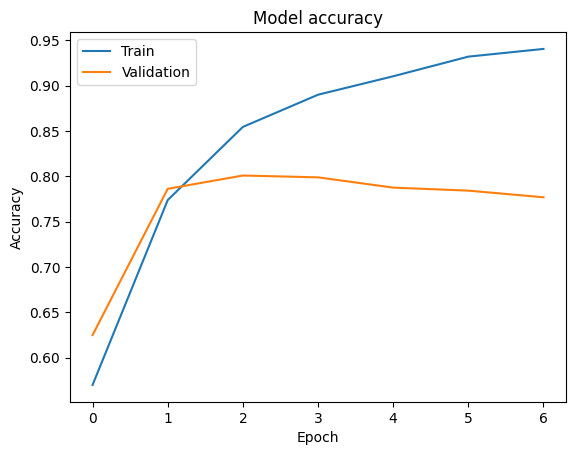

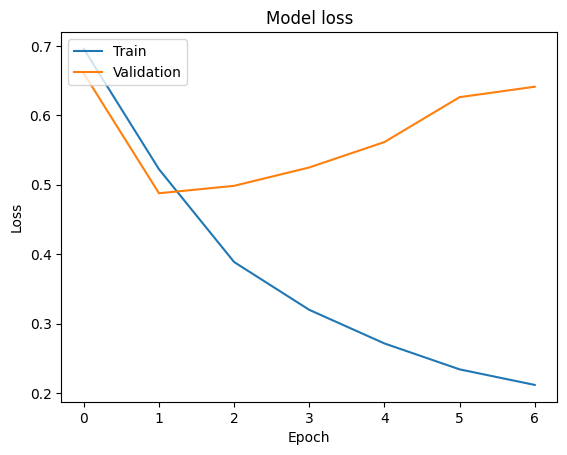

In [37]:
plot_history(history)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


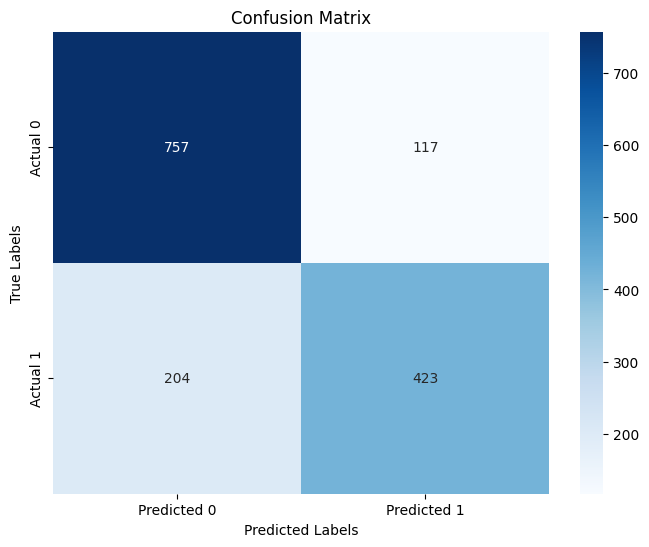

In [38]:
y_pred = model.predict(X_val.to_numpy())
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to binary predictions

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Prepare Kaggle Submission

In [39]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Prepend the keyword to the cleaned text in the test dataset
test_df['keyword'] = test_df['keyword'].fillna('nokeyword')
test_df['keyword_cleaned'] = test_df['keyword'].str.replace('%20', ' ', regex=False)
test_df['text_with_keyword'] = test_df['keyword_cleaned'] + ' ' + test_df['cleaned_text']

# Make predictions
predictions = model.predict(test_df['text_with_keyword'].to_numpy())
binary_predictions = (predictions > 0.5).astype(int)

test_df['target'] = binary_predictions

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


In [40]:
test_df[['text', 'target']].head()

,text,target
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


In [41]:
test_df[['id','target']].to_csv('submission.csv', index=False)

**Private Eval Results**

The simplified GRU model scored 0.78761 on Kaggle

# Conclusion

Ultimately, the RNN models all struggled to avoid overfitting due to the relatively small size of the data set. One approach to remedy this could be to use the initial weights from a much larger language classification model and attempt to fine-tune on the Tweets. Another approach could be to augment the data with shuffling or replacement of common terms. This approach is difficult however because it breaks some of the ordered dependency of the RNN.

Sources

https://www.tensorflow.org/text/tutorials/text_classification_rnn